In [9]:
import warnings
warnings.filterwarnings('ignore')

import read_hypergraph
import hypernetx as hnx
import networkx as nx
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from ripser import Rips

In [2]:
data_path = '../data/somemorehypergraphs/DNS_hypergraph_samples.txt'

hgraphs = read_hypergraph.read_hypergraph(data_path)

100%|██████████| 4/4 [00:00<00:00, 128.36it/s]


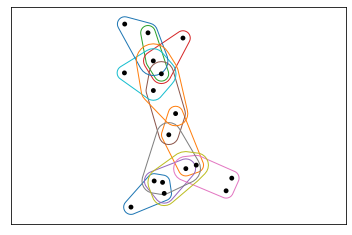

In [81]:
hg = hgraphs[0]
hnx.draw(hg, with_node_labels=False, with_edge_labels=False)

In [103]:
dual_hg = hg.dual()

node_list = list(dual_hg.nodes)
dual_hg.nodes[node_list[0]].elements

{}

In [106]:
dual_hg.edges

EntitySet(None:Edges,['103.86.122.223', '103.86.122.154', '103.86.122.225', '103.86.122.181', '103.86.122.238', '103.86.122.242', '103.86.122.173', '103.86.122.160', '103.86.122.130', '103.86.122.220', '103.86.122.149', '103.86.122.222', '103.86.122.169', '103.86.122.192', '103.86.122.195', '103.86.122.148', '103.86.122.152'],{})

In [112]:
dual_hg.incidence_dict

{'103.86.122.225': {'2wzi79.com', '37b82p.com', '8sa5zz.com', 'gs3fag.com'},
 '103.86.122.173': {'2wzi79.com'},
 '103.86.122.152': {'2wzi79.com', '37b82p.com', '8sa5zz.com'},
 '103.86.122.181': {'2wzi79.com', '8sa5zz.com', 'gs3fag.com'},
 '103.86.122.148': {'37b82p.com',
  '5bewa2.com',
  '8sa5zz.com',
  'gs3fag.com',
  'ue594m.com'},
 '103.86.122.222': {'37b82p.com', 'dyewir.com', 'ue594m.com'},
 '103.86.122.149': {'5bewa2.com', 'gs3fag.com', 'ue594m.com'},
 '103.86.122.160': {'dyewir.com', 'sgbxhi.com', 'ue594m.com'},
 '103.86.122.195': {'9mt5sd.com', 'j4bpki.com'},
 '103.86.122.154': {'8zjcn3.com',
  '9mt5sd.com',
  'dyewir.com',
  'kbeuu8.com',
  'sgbxhi.com'},
 '103.86.122.223': {'8zjcn3.com',
  '9mt5sd.com',
  'j4bpki.com',
  'kbeuu8.com',
  'sgbxhi.com'},
 '103.86.122.192': {'8zjcn3.com'},
 '103.86.122.130': {'dyewir.com', 'kbeuu8.com', 'sgbxhi.com'},
 '103.86.122.220': {'5bewa2.com'},
 '103.86.122.169': {'5bewa2.com'},
 '103.86.122.242': {'kbeuu8.com'},
 '103.86.122.238': {'j4b

In [117]:
dual_hg.nodes

EntitySet(None:Nodes,['5bewa2.com', '8zjcn3.com', '2wzi79.com', 'dyewir.com', '37b82p.com', 'gs3fag.com', 'j4bpki.com', 'ue594m.com', '8sa5zz.com', 'kbeuu8.com', 'sgbxhi.com', '9mt5sd.com'],{})

In [116]:
dual_hg.edges

EntitySet(None:Edges,['103.86.122.223', '103.86.122.154', '103.86.122.225', '103.86.122.181', '103.86.122.238', '103.86.122.242', '103.86.122.173', '103.86.122.160', '103.86.122.130', '103.86.122.220', '103.86.122.149', '103.86.122.222', '103.86.122.169', '103.86.122.192', '103.86.122.195', '103.86.122.148', '103.86.122.152'],{})

In [132]:
incidence = dual_hg.incidence_matrix()
incidence

<12x17 sparse matrix of type '<class 'numpy.int64'>'
	with 45 stored elements in Compressed Sparse Row format>

In [160]:
z = (incidence[0] + incidence[6])
(z == 2).sum()

0

In [188]:
def convert_to_line_graph(hypergraph):
    # Line-graph is a NetworkX graph
    line_graph = nx.Graph()

    # Nodes of the line-graph are nodes of the dual graph
    # OR equivalently edges of the original hypergraph
    [line_graph.add_node(node) for node in hypergraph.edges]

    node_list = list(hypergraph.edges)

    # For all pairs of edges (e1, e2), add edges such that
    # intersection(e1, e2) is not empty
    for node_idx_1, node1 in enumerate(node_list):
        for node_idx_2, node2 in enumerate(node_list[node_idx_1 + 1:]):
            vertices1 = hypergraph.edges[node1].elements
            vertices2 = hypergraph.edges[node2].elements
            if len(set(vertices1) & set(vertices2)) > 0:
                line_graph.add_edge(node1, node2)

    return line_graph

line_graph = convert_to_line_graph(hg)

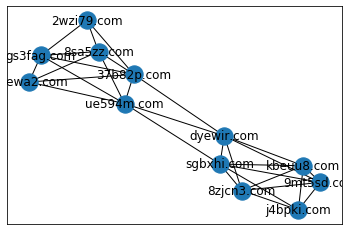

In [189]:
nx.draw_networkx(line_graph, with_labels=True)

In [4]:
# len(hg.nodes), len(hg.edges)

# hg.adjacency_matrix().todense()

# hg.edge_adjacency_matrix().todense()

# hg.auxiliary_matrix(s=2).todense()

# g = hg.bipartite()
# len(g.edges)

# import networkx as nx
# nx.draw(hg.bipartite())

# for x in hg.s_component_subgraphs():
#     hnx.draw(x, with_edge_labels=False, with_node_labels=False)

### Compute the distance matrix between all nodes

In [5]:
# from scipy.spatial.distance import pdist

# pdist(np.array([hg.nodes, hg.nodes]), hg.distance)

In [6]:
dist_mat = np.zeros((len(hg.nodes), len(hg.nodes)))

for x, node_x in tqdm(enumerate(hg.nodes), total=len(hg.nodes)):
    for y, node_y in enumerate(hg.nodes):
        if y < x:
            continue
        dist_mat[x][y] = hg.distance(node_x, node_y)
        
d = dist_mat + dist_mat.T

In [79]:
dist_mat_s2 = np.zeros((len(hg.nodes), len(hg.nodes)))

for x, node_x in tqdm(enumerate(hg.nodes), total=len(hg.nodes)):
    for y, node_y in enumerate(hg.nodes):
        if y < x:
            continue
        dist_mat[x][y] = hg.distance(node_x, node_y, s=2)
        
d2 = dist_mat_s2 + dist_mat_s2.T

In [81]:
d2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Use MDS to visualize

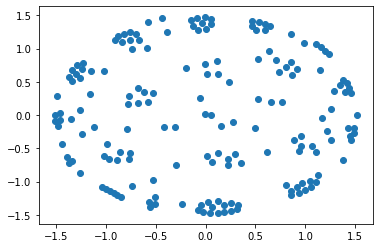

In [22]:
projector = MDS(dissimilarity='precomputed')
projection = projector.fit_transform(d)
plt.scatter(projection[:, 0], projection[:, 1])

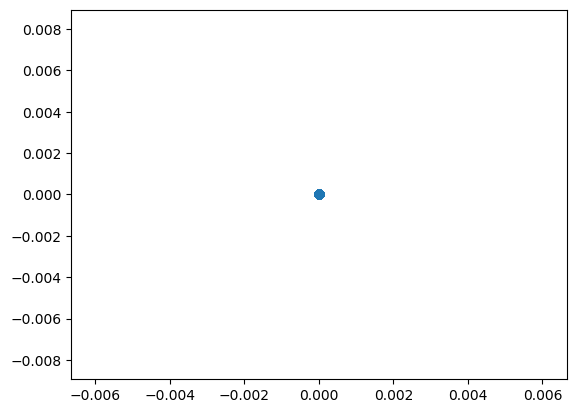

In [80]:
projector = MDS(dissimilarity='precomputed')
projection = projector.fit_transform(d2)
plt.scatter(projection[:, 0], projection[:, 1])

### Compute persistence diagram

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


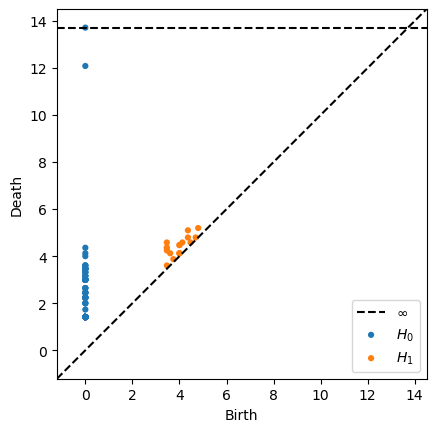

In [32]:
rips = Rips()
diagrams = rips.fit_transform(d, distance_matrix=False)
rips.plot(diagrams)

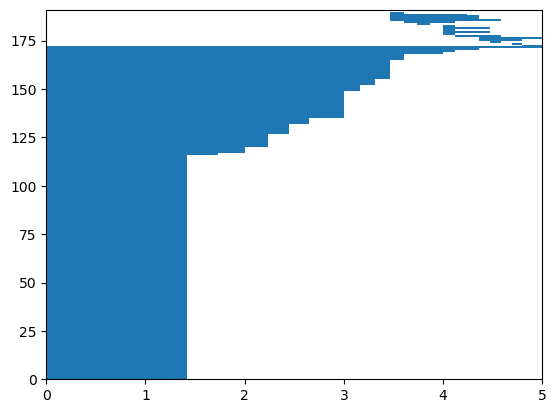

In [77]:
def draw_barcodes(dgms):
    fig, ax = plt.subplots()
    y = 0
    bars = []
    for dgm in dgms:
        for point in dgm:
            birth, death = point
            
            if death == float('inf'):
                continue
#             print(point)
            
            rect_origin = (birth, y)
            width = (death - birth)
            height = 1
            bars.append(Rectangle(rect_origin, width, height))
            
            y += 1
    pc = PatchCollection(bars)
    ax.add_collection(pc)
    ax.set_xlim(0, 5)
    ax.set_ylim(0, y+1)
    
    return bars
    
t = draw_barcodes(diagrams)
# plt.show()

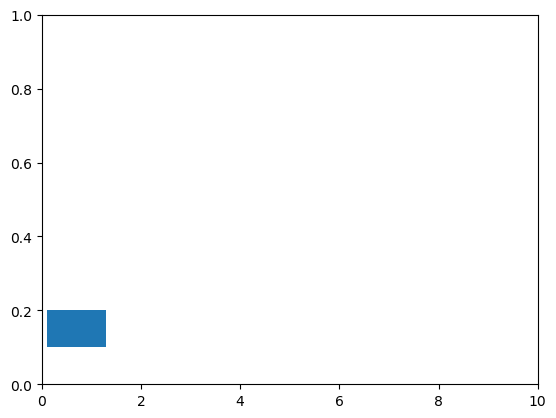

In [64]:
fig, ax = plt.subplots()
r = Rectangle((0.1, 0.1), 1.2, 0.1)
pc = PatchCollection([r])
ax.add_collection(pc)
ax.set_xlim(0, 10)
plt.show()